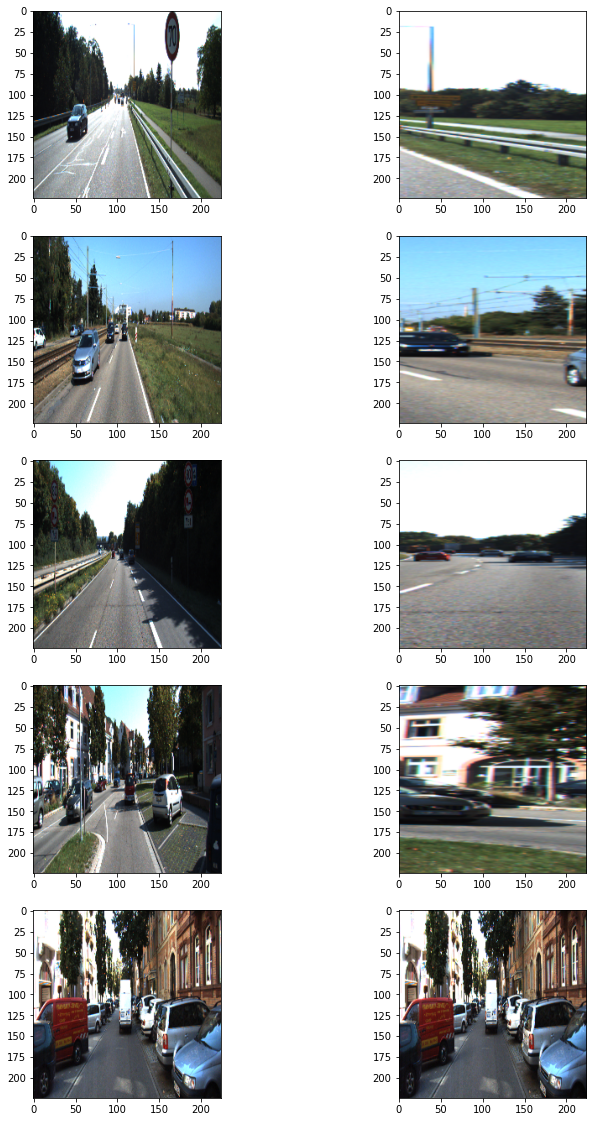

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize
from tensorflow.keras.applications.vgg16 import VGG16


def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

class KittiGenerator(tf.keras.utils.Sequence):
#     '''
#     KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
#     우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
#     '''
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
#     '''
#     dir_path: dataset의 directory path입니다.
#     batch_size: batch_size입니다.
#     img_size: preprocess에 사용할 입력이미지의 크기입니다.
#     output_size: ground_truth를 만들어주기 위한 크기입니다.
#     is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
#     augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
#     '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
               "image": _input,
               "mask": _output,
               }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

        
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [2]:
def build_model_standard(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

def handle_block_names(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name

def ConvRelu(filters, kernel_size, use_batchnorm=False, conv_name='conv', bn_name='bn', relu_name='relu'):
    def layer(x):
        x = Conv2D(filters, kernel_size, padding="same", name=conv_name, use_bias=not(use_batchnorm))(x)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name)(x)
        x = Activation('relu', name=relu_name)(x)
        return x
    return layer


def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     use_batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '1', bn_name=bn_name + '1', relu_name=relu_name + '1')(x)

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer


def Transpose2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), use_batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name, use_bias=not(use_batchnorm))(input_tensor)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer

from functools import wraps
import numpy as np

def get_layer_number(model, layer_name):
    """
    Help find layer in Keras model by name
    Args:
        model: Keras `Model`
        layer_name: str, name of layer
    Returns:
        index of layer
    Raises:
        ValueError: if model does not contains layer with such name
    """
    for i, l in enumerate(model.layers):
        if l.name == layer_name:
            return i
    raise ValueError('No layer with name {} in  model {}.'.format(layer_name, model.name))


def to_tuple(x):
    if isinstance(x, tuple):
        if len(x) == 2:
            return x
    elif np.isscalar(x):
        return (x, x)

    raise ValueError('Value should be tuple of length 2 or int value, got "{}"'.format(x))
    

def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return

backbones = {
    "vgg16": VGG16,
}

def get_backbone(name, *args, **kwargs):
    return backbones[name](*args, **kwargs)

def build_unet(backbone, classes, skip_connection_layers,
               decoder_filters=(256,128,64,32,16),
               upsample_rates=(2,2,2,2,2),
               n_upsample_blocks=5,
               block_type='upsampling',
               activation='sigmoid',
               use_batchnorm=True):

    input = backbone.input
    x = backbone.output

    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    # convert layer names to indices
    skip_connection_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                               for l in skip_connection_layers])

    for i in range(n_upsample_blocks):

        # check if there is a skip connection
        skip_connection = None
        if i < len(skip_connection_idx):
            skip_connection = backbone.layers[skip_connection_idx[i]].output

        upsample_rate = to_tuple(upsample_rates[i])

        x = up_block(decoder_filters[i], i, upsample_rate=upsample_rate,
                     skip=skip_connection, use_batchnorm=use_batchnorm)(x)

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    model = Model(input, x)

    return model
    
DEFAULT_SKIP_CONNECTIONS = {
    'vgg16':            ('block5_conv3', 'block4_conv3', 'block3_conv3', 'block2_conv2', 'block1_conv2'),
    'vgg19':            ('block5_conv4', 'block4_conv4', 'block3_conv4', 'block2_conv2', 'block1_conv2'),
    'resnet18':         ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'), # check 'bn_data'
    'resnet34':         ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'resnet50':         ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'resnet101':        ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'resnet152':        ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'resnext50':        ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'resnext101':       ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'inceptionv3':          (228, 86, 16, 9),
    'inceptionresnetv2':    (594, 260, 16, 9),
    'densenet121':          (311, 139, 51, 4),
    'densenet169':          (367, 139, 51, 4),
    'densenet201':          (479, 139, 51, 4),
}


def Unet_plus(backbone_name='vgg16',
         input_shape=(None, None, 3),
         input_tensor=None,
         encoder_weights='imagenet',
         freeze_encoder=False,
         skip_connections='default',
         decoder_block_type='upsampling',
         decoder_filters=(256,128,64,32,16),
         decoder_use_batchnorm=True,
         n_upsample_blocks=5,
         upsample_rates=(2,2,2,2,2),
         classes=1,
         activation='sigmoid'):
    """
    Args:
        backbone_name: (str) look at list of available backbones.
        input_shape:  (tuple) dimensions of input data (H, W, C)
        input_tensor: keras tensor
        encoder_weights: one of `None` (random initialization), 
            'imagenet' (pre-training on ImageNet), 
            'dof' (pre-training on DoF)
        freeze_encoder: (bool) Set encoder layers weights as non-trainable. Useful for fine-tuning
        skip_connections: if 'default' is used take default skip connections,
            else provide a list of layer numbers or names starting from top of model
        decoder_block_type: (str) one of 'upsampling' and 'transpose' (look at blocks.py)
        decoder_filters: (int) number of convolution layer filters in decoder blocks
        decoder_use_batchnorm: (bool) if True add batch normalisation layer between `Conv2D` ad `Activation` layers
        n_upsample_blocks: (int) a number of upsampling blocks
        upsample_rates: (tuple of int) upsampling rates decoder blocks
        classes: (int) a number of classes for output
        activation: (str) one of keras activations for last model layer
    Returns:
        keras.models.Model instance
    """



    backbone = get_backbone(backbone_name,
                            input_shape=input_shape,
                            input_tensor=input_tensor,
                            weights=encoder_weights,
                            include_top=False)

    if skip_connections == 'default':
        skip_connections = DEFAULT_SKIP_CONNECTIONS[backbone_name]

    model = build_unet(backbone,
                       classes,
                       skip_connections,
                       decoder_filters=decoder_filters,
                       block_type=decoder_block_type,
                       activation=activation,
                       n_upsample_blocks=n_upsample_blocks,
                       upsample_rates=upsample_rates,
                       use_batchnorm=decoder_use_batchnorm)

    # lock encoder weights for fine-tuning
    if freeze_encoder:
        freeze_model(backbone)

#     model.name = 'u-{}'.format(backbone_name)

    return model


In [3]:
model2_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

model = Unet_plus()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history_Unet_plus = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=300,
 )

model.save(model2_path)  #학습한 모델을 저장
hist_Unet_plus_df = pd.DataFrame(history_Unet_plus.history) 
hist_Unet_plus_csv_file = 'history_Unet_plus.csv'
with open(hist_Unet_plus_csv_file, mode='w') as f:
    hist_Unet_plus_df.to_csv(f)

Epoch 1/300
11/11 [==============================] - 17s 387ms/step - loss: 0.5260 - val_loss: 0.2407
Epoch 2/300
11/11 [==============================] - 4s 354ms/step - loss: 0.4364 - val_loss: 0.1720
Epoch 3/300
11/11 [==============================] - 4s 354ms/step - loss: 0.3877 - val_loss: 0.1600
Epoch 4/300
11/11 [==============================] - 4s 355ms/step - loss: 0.3565 - val_loss: 0.1341
Epoch 5/300
11/11 [==============================] - 4s 358ms/step - loss: 0.3285 - val_loss: 0.1111
Epoch 6/300
11/11 [==============================] - 4s 358ms/step - loss: 0.3021 - val_loss: 0.1239
Epoch 7/300
11/11 [==============================] - 4s 360ms/step - loss: 0.2784 - val_loss: 0.1263
Epoch 8/300
11/11 [==============================] - 4s 361ms/step - loss: 0.2574 - val_loss: 0.0985
Epoch 9/300
11/11 [==============================] - 4s 358ms/step - loss: 0.2407 - val_loss: 0.0727
Epoch 10/300
11/11 [==============================] - 4s 356ms/step - loss: 0.2226 - val_l

Epoch 161/300
11/11 [==============================] - 4s 350ms/step - loss: 0.0113 - val_loss: 0.0238
Epoch 162/300
11/11 [==============================] - 4s 352ms/step - loss: 0.0105 - val_loss: 0.0194
Epoch 163/300
11/11 [==============================] - 4s 350ms/step - loss: 0.0106 - val_loss: 0.0217
Epoch 164/300
11/11 [==============================] - 4s 351ms/step - loss: 0.0088 - val_loss: 0.0217
Epoch 165/300
11/11 [==============================] - 4s 351ms/step - loss: 0.0099 - val_loss: 0.0202
Epoch 166/300
11/11 [==============================] - 4s 351ms/step - loss: 0.0101 - val_loss: 0.0215
Epoch 167/300
11/11 [==============================] - 4s 352ms/step - loss: 0.0127 - val_loss: 0.0235
Epoch 168/300
11/11 [==============================] - 4s 350ms/step - loss: 0.0106 - val_loss: 0.0222
Epoch 169/300
11/11 [==============================] - 4s 351ms/step - loss: 0.0098 - val_loss: 0.0270
Epoch 170/300
11/11 [==============================] - 4s 351ms/step - lo

In [11]:
model1_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model_standard()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history_Unet = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=300,
 )

model.save(model1_path)  #학습한 모델을 저장
hist_Unet_df = pd.DataFrame(history_Unet.history) 
hist_Unet_csv_file = 'history_Unet.csv'
with open(hist_Unet_csv_file, mode='w') as f:
    hist_Unet_df.to_csv(f)

Epoch 1/300
11/11 [==============================] - 8s 584ms/step - loss: 0.6929 - val_loss: 0.6921
Epoch 2/300
11/11 [==============================] - 6s 571ms/step - loss: 0.6872 - val_loss: 0.6743
Epoch 3/300
11/11 [==============================] - 6s 576ms/step - loss: 0.6565 - val_loss: 0.6025
Epoch 4/300
11/11 [==============================] - 6s 572ms/step - loss: 0.1790 - val_loss: 0.0383
Epoch 5/300
11/11 [==============================] - 6s 564ms/step - loss: 0.0394 - val_loss: 0.0337
Epoch 6/300
11/11 [==============================] - 6s 568ms/step - loss: 0.0326 - val_loss: 0.0353
Epoch 7/300
11/11 [==============================] - 6s 570ms/step - loss: 0.0301 - val_loss: 0.0281
Epoch 8/300
11/11 [==============================] - 6s 571ms/step - loss: 0.0337 - val_loss: 0.0280
Epoch 9/300
11/11 [==============================] - 6s 573ms/step - loss: 0.0287 - val_loss: 0.0262
Epoch 10/300
11/11 [==============================] - 6s 575ms/step - loss: 0.0283 - val_lo

Epoch 161/300
11/11 [==============================] - 6s 576ms/step - loss: 0.0108 - val_loss: 0.0193
Epoch 162/300
11/11 [==============================] - 6s 576ms/step - loss: 0.0107 - val_loss: 0.0169
Epoch 163/300
11/11 [==============================] - 6s 577ms/step - loss: 0.0086 - val_loss: 0.0168
Epoch 164/300
11/11 [==============================] - 6s 577ms/step - loss: 0.0071 - val_loss: 0.0248
Epoch 165/300
11/11 [==============================] - 6s 577ms/step - loss: 0.0092 - val_loss: 0.0151
Epoch 166/300
11/11 [==============================] - 6s 577ms/step - loss: 0.0080 - val_loss: 0.0186
Epoch 167/300
11/11 [==============================] - 6s 577ms/step - loss: 0.0096 - val_loss: 0.0159
Epoch 168/300
11/11 [==============================] - 6s 577ms/step - loss: 0.0123 - val_loss: 0.0162
Epoch 169/300
11/11 [==============================] - 6s 576ms/step - loss: 0.0081 - val_loss: 0.0179
Epoch 170/300
11/11 [==============================] - 6s 576ms/step - lo

In [12]:
model1 = tf.keras.models.load_model(model1_path)
model2 = tf.keras.models.load_model(model2_path)

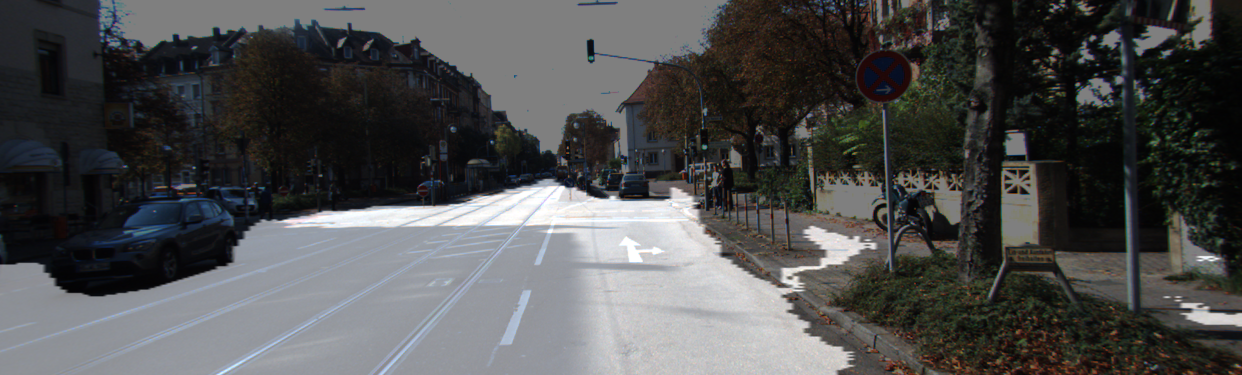

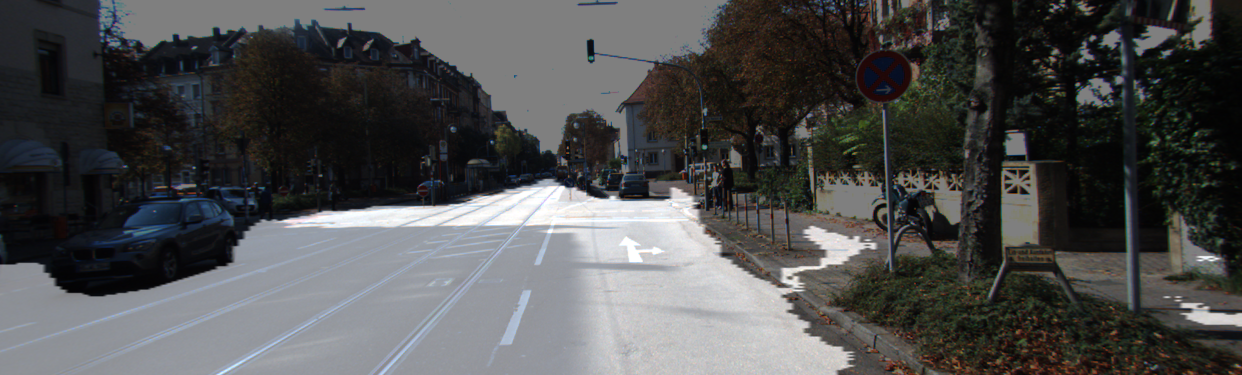

IoU : 0.918233


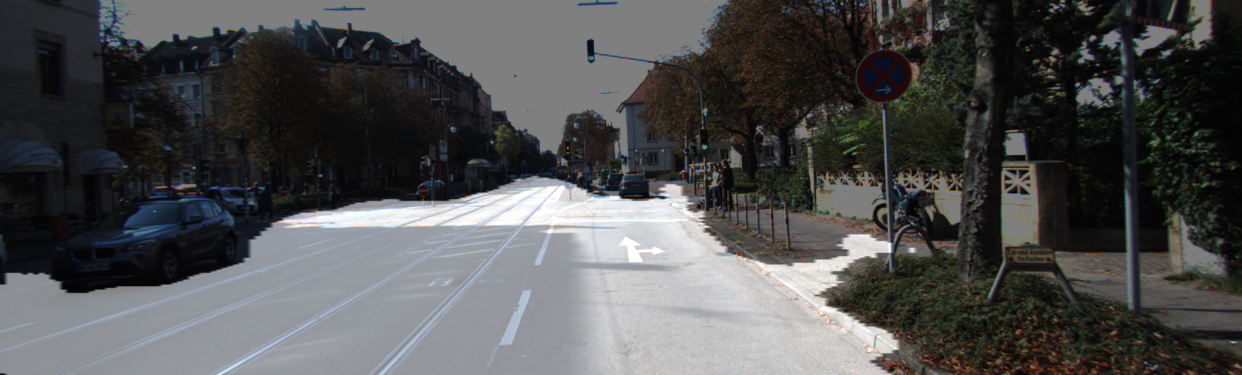

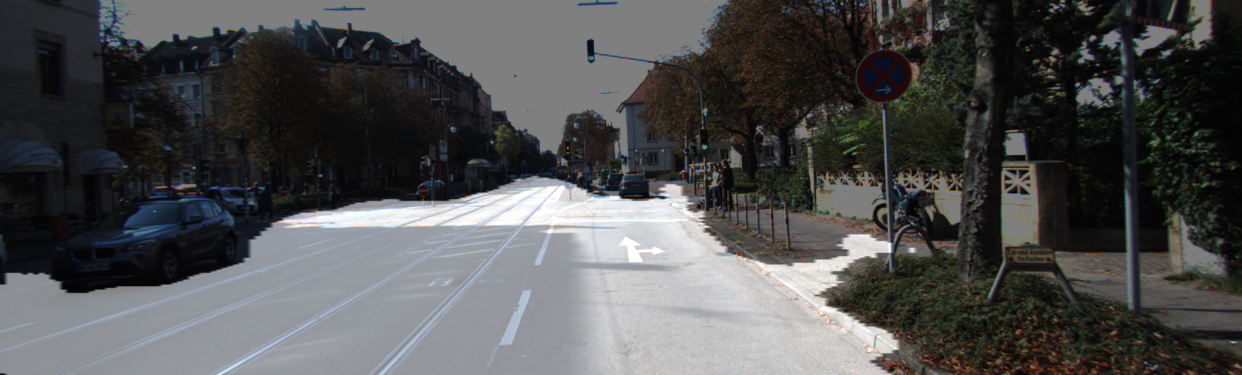

IoU : 0.917313


0.9173132343161161

In [17]:
def get_output1(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output     # TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.
    


def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

def get_output2(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _
    
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output1(
     model1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output2(
     model1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)


i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output1(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output2(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

(0.0, 0.05)

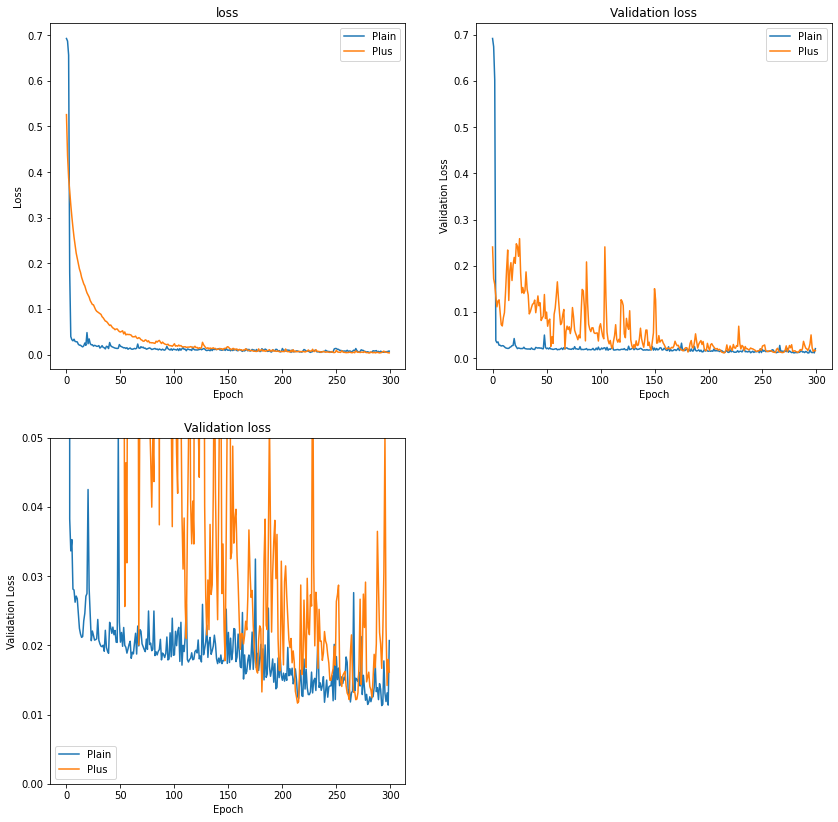

In [15]:
plain = pd.read_csv("history_Unet.csv")
plus = pd.read_csv("history_Unet_plus.csv")
fig = plt.figure(figsize = (14, 14))

plt.subplot(2,2,1)
plt.plot(plain['loss'])
plt.plot(plus['loss'])

plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Plain', 'Plus'])

plt.subplot(2,2,2)
plt.plot(plain['val_loss'])
plt.plot(plus['val_loss'])

plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Plain', 'Plus'])

plt.subplot(2,2,3)
plt.plot(plain['val_loss'])
plt.plot(plus['val_loss'])

plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Plain', 'Plus'])
plt.ylim(0, 0.05)


## 회고
모델 히스토리 저장하고 불러오는 코드는 광석님 코드를 참고하였고, Unet++가 Unet보다 우월한 결과를 냈다는 근거는 찾지 못하였다.